# Setup

## Import libraries

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
from os import chdir, mkdir, getcwd, listdir
from os.path import join
import requests
from zipfile import ZipFile
import matplotlib.pyplot as plt
import time
import pickle

In [9]:
HOME = getcwd()

## Download dataset

### FAR Part 121

In [10]:
filepath = join(HOME, 'Regulations', 'FAR_Part121_nodes_labelled.xlsx')
df_FAA = pd.read_excel(filepath)[['title', 'requirement', 'label', 'tag']]
df_FAA

,title,requirement,label,tag
0,§ 121.1(a),§ 121.1 Applicability.\nThis part prescribes...,0,title only
1,§ 121.1(b),§ 121.1 Applicability.\nThis part prescribes...,0,title only
2,§ 121.1(c),§ 121.1 Applicability.\nThis part prescribes...,0,title only
3,§ 121.1(d)(1),§ 121.1 Applicability.\nThis part prescribes...,0,title only
4,§ 121.1(d)(2),§ 121.1 Applicability.\nThis part prescribes...,0,title only
...,...,...,...,...
2354,§ 121.1500(b)(3),§ 121.1500 SFAR No. 111 - Lavatory Oxygen Sy...,2,operator
2355,§ 121.1500(b)(4),§ 121.1500 SFAR No. 111 - Lavatory Oxygen Sy...,2,operator
2356,§ 121.1500(b)(5),§ 121.1500 SFAR No. 111 - Lavatory Oxygen Sy...,2,operator
2357,§ 121.1500(c),§ 121.1500 SFAR No. 111 - Lavatory Oxygen Sy...,2,operator


In [11]:
df_FAA.groupby('tag').agg({'tag':'count'})

,tag
tag,
aircraft,769
operator,1376
title only,214


### RBAC 121

In [12]:
filepath = join(HOME, 'Regulations', 'RBAC121_nodes_en_labelled.xlsx')
df_ANAC = pd.read_excel(filepath)[['title', 'requirement_en', 'label', 'tag']]

In [13]:
df_ANAC.groupby('tag').agg({'tag':'count'})

,tag
tag,
Aircraft,771
Operator,1144
Title Only,217


## Create and fit tokenizer

In [14]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(df_FAA.requirement.to_list())
tokenizer.fit_on_texts(df_ANAC.requirement_en.to_list())

dict_size = len(tokenizer.word_index)

print('Dictionary size: {}'.format(dict_size))
print('Word examples: ', end='')
print(list(tokenizer.word_index)[:100])

Dictionary size: 6180
Word examples: ['<OOV>', 'the', 'of', 'and', 'a', 'in', '121', 'to', 'for', 'or', 'this', 'flight', 'that', 'must', 'an', 'by', 'certificate', 'with', '§', 'is', 'section', 'airplane', 'be', 'each', 'may', 'as', 'holder', 'training', 'b', 'paragraph', 'no', 'at', 'on', 'required', 'following', 'requirements', 'operations', '1', 'data', 'person', 'c', 'airplanes', 'aircraft', 'unless', 'under', 'any', 'are', 'not', '2', 'equipment', 'approved', 'it', 'one', 'if', 'pilot', 'program', 'part', 'except', 'from', 'emergency', 'type', 'system', 'provided', 'engine', 'passenger', 'information', 'd', 'which', 'after', 'all', 'more', 'maintenance', 'use', 'operate', 'category', 'than', 'transport', 'operating', 'i', 'has', 'recorders', '3', 'least', 'crew', 'time', 'other', 'specified', 'command', 'e', 'include', 'digital', 'etops', 'can', 'route', 'limitations', 'have', 'fuel', '25', 'operation', 'operational']


## Download GloVe

In [15]:
URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
chdir(HOME)

if 'GloVe' not in listdir():
    mkdir('GloVe')

chdir(join(HOME, 'GloVe'))

if 'glove.6B.300d.txt' not in listdir():
    r = requests.get(URL)
    with open('glove.6B.zip', 'wb') as file:
        file.write(r.content)
    zipfile = ZipFile('glove.6B.zip')
    zipfile.extractall()
    
chdir(HOME)

## Create embedding matrix

In [16]:
chdir(HOME)

keys, vectors = [], []

with open(join(HOME, 'GloVe', 'glove.6B.300d.txt'), encoding='utf-8') as file:
    for line in file:
        key, vector = line.split(' ', maxsplit=1)
        vector = np.array(vector.split(' ')).astype('float')
        keys.append(key)
        vectors.append(vector)

embedding_dict = dict(zip(keys, vectors))

In [17]:
embedding_dim = 300
embedding_matrix = np.zeros((dict_size+1, embedding_dim))

print('Words without available embedding:')
for pos, key in enumerate(tokenizer.word_index.keys()):
    if key in embedding_dict.keys():
        embedding_matrix[pos,:] = embedding_dict[key]
    else:
        print(key, end=', ')

Words without available embedding:
<OOV>, §, holder's, aqp, §§, nº, “when, installed”, pmac, nontransport, flightcrew, ewis, manufacturer's, operator's, “operational, airplane's, sgso, 344a, inspac, turbopropeller, °c, aircraft's, objectives”, ​​being, ​​recorded, redispatch, utlitize, fstd, nonturbine, pilot's, safety”, “no, pdsc, ​​the, vso2, observer's, reseating, “conditions, icing”, 412a, sr422b, “e”, smoking”, microlamberts, crewmember's, dfdr, person's, “training, “civil, ​​operations, “d”, nonpressurized, fdau, “promotion, 422b, clearway, “b”, sd3, wv050, fimm, anac's, fl250, 412b, mdso, management”, rffs, “a”, passenger's, govinfo, rbha, regulation”, plane's, “responsibility, security”, qualification”, sr422, 422a, sr422a, “c”, dfdau, lrns, lrcs, 119b, 119a, c123a, ifsd, h25, crew's, ​​to, nadso, idso, reqso, belt”, 04a, mechanic's, pretakeoff, applicant's, series6048, washbasins, guarantee”, “management, commitment”, “pre, coordination”, stopways, adr's, 079, child's, “fasten

## Prepare dataset object

In [18]:
y = np.array(df_FAA.label)
x = df_FAA.requirement.map(lambda x: x.split('  ')[1])
x = np.array(x)
x = tokenizer.texts_to_sequences(x)

y_valid = np.array(df_ANAC.label)
x_valid = df_ANAC.requirement_en
x_valid = np.array(x_valid)
x_valid = tokenizer.texts_to_sequences(x_valid)

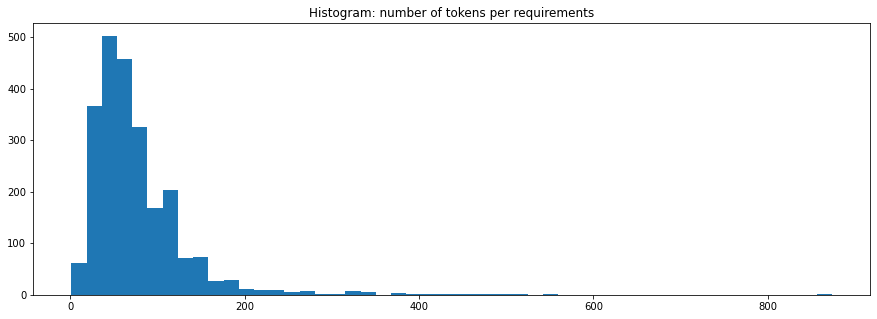

In [19]:
plt.figure(figsize = (15,5))
plt.hist(np.array([len(seq) for seq in x]), 50)
plt.title('Histogram: number of tokens per requirements')
plt.show()

In [20]:
sequence_length = 200

x = tf.keras.preprocessing.sequence.pad_sequences(x,maxlen=sequence_length, truncating='pre', padding='pre')
x = np.array(x)

x_valid = tf.keras.preprocessing.sequence.pad_sequences(x_valid,maxlen=sequence_length, truncating='pre', padding='pre')
x_valid = np.array(x_valid)

In [21]:
x = tf.data.Dataset.from_tensor_slices(x)
#x = tf.data.Dataset.from_tensor_slices(np.zeros((y.shape[0], sequence_length))) # uncomment to test with null input
y = tf.data.Dataset.from_tensor_slices(y)
dataset = tf.data.Dataset.zip((x,y)).shuffle(buffer_size = 200, seed=20210413)

x_valid = tf.data.Dataset.from_tensor_slices(x_valid)
y_valid = tf.data.Dataset.from_tensor_slices(y_valid)
valid = tf.data.Dataset.zip((x_valid, y_valid))

# Build model

In [55]:
# hyperparameters
h = {'epochs' : 200,
     'learning_rate' : .01,
     'batch_size' : 256,
     'recurrent_units' : 128,
     'dropout' : .6,
     'recurrent_dropout' : 0,
     'reduce_lr_factor' : 0.95,
     'reduce_lr_patience' : 0,
     'early_stopping_patience' : 50}

verbose = 1

In [56]:
model = tf.keras.models.Sequential(name = 'GRU_stack_Softmax')

# add embedding layer
model.add(tf.keras.layers.Embedding(input_dim = dict_size + 1,
                                    output_dim = embedding_dim,
                                    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                                    input_shape = [sequence_length],
                                    trainable = False,
                                    name = "GloVe_6B_300D"))

# add recurrent layers
model.add(tf.keras.layers.GRU(h['recurrent_units'],
                              dropout = h['dropout'],
                              recurrent_dropout = h['recurrent_dropout'],
                              return_sequences = True,
                              name = "GRU_1"))

model.add(tf.keras.layers.GRU(h['recurrent_units'],
                              dropout = h['dropout'],
                              recurrent_dropout = h['recurrent_dropout'],
                              return_sequences = False,
                              name = "GRU_2"))

# add dense output layer
model.add(tf.keras.layers.Dense(3, 'softmax', name = 'Softmax'))

# create callbacks
cb_plateau = tf.keras.callbacks.ReduceLROnPlateau(factor = h['reduce_lr_factor'], 
                                                  patience = h['reduce_lr_patience'],
                                                  min_lr = h['learning_rate'] / 1000,
                                                  verbose = 1)
cb_stopping = tf.keras.callbacks.EarlyStopping(patience = h['early_stopping_patience'],
                                               restore_best_weights = True,
                                               monitor = 'val_sparse_categorical_accuracy',
                                               verbose = 1)

# compile model
model.compile(optimizer = tf.keras.optimizers.Nadam(h['learning_rate']),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])
model.summary()

Model: "GRU_stack_Softmax"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GloVe_6B_300D (Embedding)    (None, 200, 300)          1854300   
_________________________________________________________________
GRU_1 (GRU)                  (None, 200, 128)          165120    
_________________________________________________________________
GRU_2 (GRU)                  (None, 128)               99072     
_________________________________________________________________
Softmax (Dense)              (None, 3)                 387       
Total params: 2,118,879
Trainable params: 264,579
Non-trainable params: 1,854,300
_________________________________________________________________


In [57]:
history = model.fit(dataset.batch(h['batch_size']),
                    epochs = h['epochs'],
                    verbose = verbose,
                    validation_data = valid.batch(h['batch_size']),
                    callbacks = [cb_plateau, cb_stopping])      

Epoch 1/200
10/10 [==============================] - 51s 5s/step - loss: 0.9667 - sparse_categorical_accuracy: 0.6613 - val_loss: 1.3422 - val_sparse_categorical_accuracy: 0.5366
Epoch 2/200
10/10 [==============================] - ETA: 0s - loss: 0.9535 - sparse_categorical_accuracy: 0.6660
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.009499999787658453.
10/10 [==============================] - 51s 5s/step - loss: 0.9535 - sparse_categorical_accuracy: 0.6660 - val_loss: 1.4135 - val_sparse_categorical_accuracy: 0.5366
Epoch 3/200
10/10 [==============================] - 47s 5s/step - loss: 0.9280 - sparse_categorical_accuracy: 0.6240 - val_loss: 1.3016 - val_sparse_categorical_accuracy: 0.5366
Epoch 4/200
10/10 [==============================] - ETA: 0s - loss: 0.9040 - sparse_categorical_accuracy: 0.6130
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.009024999709799886.
10/10 [==============================] - 48s 5s/step - loss: 0.9040 - sparse_categorical_

Epoch 31/200
10/10 [==============================] - 47s 5s/step - loss: 0.1986 - sparse_categorical_accuracy: 0.9254 - val_loss: 0.5266 - val_sparse_categorical_accuracy: 0.8138
Epoch 32/200
10/10 [==============================] - ETA: 0s - loss: 0.1746 - sparse_categorical_accuracy: 0.9356
Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.004181203688494861.
10/10 [==============================] - 48s 5s/step - loss: 0.1746 - sparse_categorical_accuracy: 0.9356 - val_loss: 0.6756 - val_sparse_categorical_accuracy: 0.7777
Epoch 33/200
10/10 [==============================] - ETA: 0s - loss: 0.1825 - sparse_categorical_accuracy: 0.9326
Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.003972143703140319.
10/10 [==============================] - 48s 5s/step - loss: 0.1825 - sparse_categorical_accuracy: 0.9326 - val_loss: 0.6705 - val_sparse_categorical_accuracy: 0.7786
Epoch 34/200
10/10 [==============================] - ETA: 0s - loss: 0.1692 - sparse_categorical_

10/10 [==============================] - ETA: 0s - loss: 0.0539 - sparse_categorical_accuracy: 0.9809
Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.0017482464434579014.
10/10 [==============================] - 48s 5s/step - loss: 0.0539 - sparse_categorical_accuracy: 0.9809 - val_loss: 0.4228 - val_sparse_categorical_accuracy: 0.8963
Epoch 60/200
10/10 [==============================] - ETA: 0s - loss: 0.0534 - sparse_categorical_accuracy: 0.9813
Epoch 00060: ReduceLROnPlateau reducing learning rate to 0.0016608341655228287.
10/10 [==============================] - 47s 5s/step - loss: 0.0534 - sparse_categorical_accuracy: 0.9813 - val_loss: 0.4324 - val_sparse_categorical_accuracy: 0.8931
Epoch 61/200
10/10 [==============================] - ETA: 0s - loss: 0.0511 - sparse_categorical_accuracy: 0.9826
Epoch 00061: ReduceLROnPlateau reducing learning rate to 0.0015777924738358705.
10/10 [==============================] - 49s 5s/step - loss: 0.0511 - sparse_categorical_accur

Epoch 82/200
10/10 [==============================] - ETA: 0s - loss: 0.0365 - sparse_categorical_accuracy: 0.9864
Epoch 00082: ReduceLROnPlateau reducing learning rate to 0.0005373355932533741.
10/10 [==============================] - 47s 5s/step - loss: 0.0365 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.4231 - val_sparse_categorical_accuracy: 0.9029
Epoch 83/200
10/10 [==============================] - ETA: 0s - loss: 0.0321 - sparse_categorical_accuracy: 0.9886
Epoch 00083: ReduceLROnPlateau reducing learning rate to 0.0005104688025312498.
10/10 [==============================] - 47s 5s/step - loss: 0.0321 - sparse_categorical_accuracy: 0.9886 - val_loss: 0.4221 - val_sparse_categorical_accuracy: 0.9038
Epoch 84/200
10/10 [==============================] - ETA: 0s - loss: 0.0313 - sparse_categorical_accuracy: 0.9894
Epoch 00084: ReduceLROnPlateau reducing learning rate to 0.00048494534858036783.
10/10 [==============================] - 49s 5s/step - loss: 0.0313 - sparse_cat

Epoch 105/200
10/10 [==============================] - ETA: 0s - loss: 0.0362 - sparse_categorical_accuracy: 0.9860
Epoch 00105: ReduceLROnPlateau reducing learning rate to 0.00016515375318704173.
10/10 [==============================] - 44s 4s/step - loss: 0.0362 - sparse_categorical_accuracy: 0.9860 - val_loss: 0.4267 - val_sparse_categorical_accuracy: 0.9038
Epoch 106/200
10/10 [==============================] - ETA: 0s - loss: 0.0288 - sparse_categorical_accuracy: 0.9911
Epoch 00106: ReduceLROnPlateau reducing learning rate to 0.00015689607243984938.
10/10 [==============================] - 45s 5s/step - loss: 0.0288 - sparse_categorical_accuracy: 0.9911 - val_loss: 0.4266 - val_sparse_categorical_accuracy: 0.9043
Epoch 107/200
10/10 [==============================] - ETA: 0s - loss: 0.0289 - sparse_categorical_accuracy: 0.9886
Epoch 00107: ReduceLROnPlateau reducing learning rate to 0.0001490512688178569.
10/10 [==============================] - 45s 4s/step - loss: 0.0289 - sparse

In [58]:
loss, accuracy = model.evaluate(dataset.batch(128), verbose=0)
loss = np.round(loss, 6)
accuracy = np.round(accuracy, 3)
certainty = np.round(np.exp(-loss), 3)

val_loss, val_accuracy = model.evaluate(valid.batch(128), verbose=0)
val_loss = np.round(val_loss, 6)
val_accuracy = np.round(val_accuracy, 3)
val_certainty = np.round(np.exp(-val_loss), 3)

print("Model performance:")
print("Loss (train | valid): {} | {}".format(loss, val_loss))
print("Accuracy (train | valid): {} | {}".format(accuracy, val_accuracy))

Model performance:
Loss (train | valid): 0.00554 | 0.413285
Accuracy (train | valid): 0.998 | 0.908


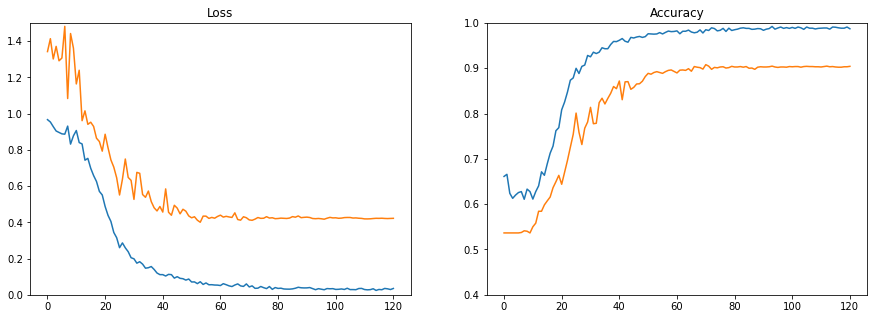

In [59]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0,1.5))

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.ylim((.4,1))

plt.show()

In [60]:
chdir(HOME)

timestamp = time.strftime('%Y-%m-%d_%H-%M-%S')
model_filename = 'model___' + timestamp + '___' + model.name + '.h5'
tokenizer_filename = 'tokenizer___' + timestamp + '.h5'

if 'models' not in listdir():
    mkdir('models')

model.save(join(HOME, 'models', model_filename))

with open(join(HOME, 'models', tokenizer_filename), 'wb') as file:
    pickle.dump(tokenizer, file)
    
print(model_filename)
print(tokenizer_filename)
    
# load with:
#with open(join(HOME, 'models', tokenizer_filename), 'rb') as file:
#    tk_load = pickle.load(file)

model___2021-04-27_00-01-32___GRU_stack_Softmax.h5
tokenizer___2021-04-27_00-01-32.h5


Model performance:
Loss (train | valid): 0.00554 | 0.413285
Accuracy (train | valid): 0.998 | 0.908
{'epochs': 200, 'learning_rate': 0.01, 'batch_size': 256, 'recurrent_units': 128, 'dropout': 0.6, 'recurrent_dropout': 0, 'reduce_lr_factor': 0.95, 'reduce_lr_patience': 0, 'early_stopping_patience': 50}
model___2021-04-27_00-01-32___GRU_stack_Softmax.h5
tokenizer___2021-04-27_00-01-32.h5


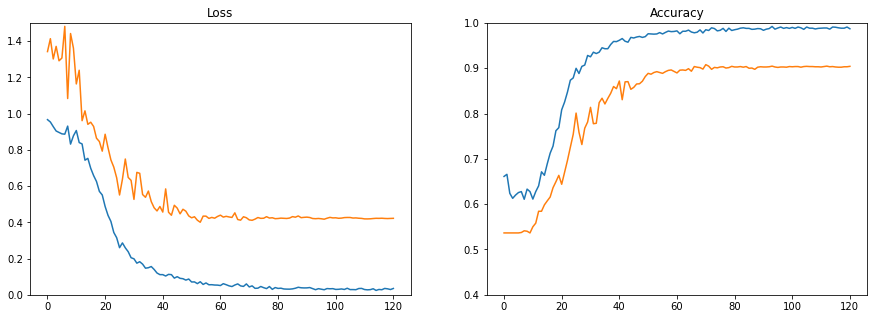

In [61]:
# print performance log (everything combined for 1 screenshot!)

print("Model performance:")
print("Loss (train | valid): {} | {}".format(loss, val_loss))
print("Accuracy (train | valid): {} | {}".format(accuracy, val_accuracy))

print(h)

print(model_filename)
print(tokenizer_filename)

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0,1.5))

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.ylim((.4,1))

plt.show()